<a href="https://colab.research.google.com/github/Rahulnigahi123/Face-recognition/blob/master/3a)Garment_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paramaggarwal/fashion-product-images-small

 96% 541M/565M [00:04<00:00, 212MB/s]
100% 565M/565M [00:04<00:00, 135MB/s]


In [ ]:
! unzip fashion-product-images-small.zip

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/myntradataset/styles.csv',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 1

In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
import numpy as np
from numpy.linalg import norm
import os
from tqdm import tqdm
import pickle

In [21]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

94781440/94765736 [==============================] - 0s 0us/step


In [22]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result

In [23]:
filenames = []

for file in os.listdir('/content/myntradataset/images'):
    filenames.append(os.path.join('/content/myntradataset/images',file))

feature_list = []

for file in tqdm(filenames):
    feature_list.append(extract_features(file,model))

pickle.dump(feature_list,open('embeddings.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl','wb'))

100%|██████████| 44441/44441 [42:57<00:00, 17.24it/s]


In [25]:
import pickle
import tensorflow
import numpy as np
from numpy.linalg import norm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.neighbors import NearestNeighbors
import cv2

In [26]:
feature_list = np.array(pickle.load(open('embeddings.pkl','rb')))
filenames = pickle.load(open('filenames.pkl','rb'))

model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [36]:
img = image.load_img('/content/blue-jeans-isolated-white-background-blue-jeans-isolated-white-126824335.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = model.predict(preprocessed_img).flatten()
normalized_result = result / norm(result)


In [37]:
from google.colab.patches import cv2_imshow

[[37236 29920 42930 18721 16605  3934]]


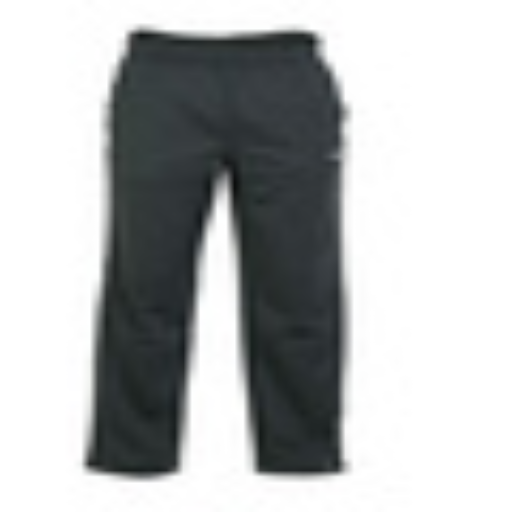

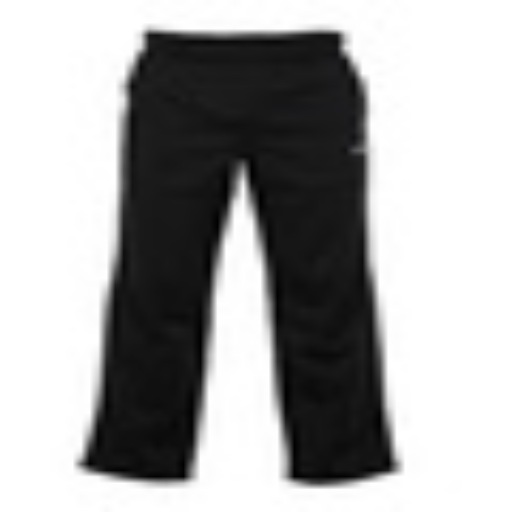

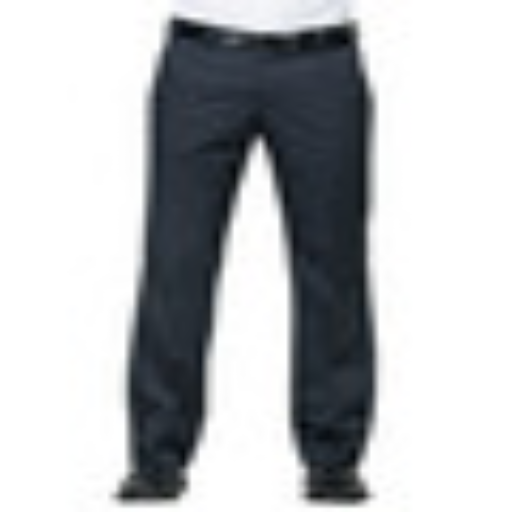

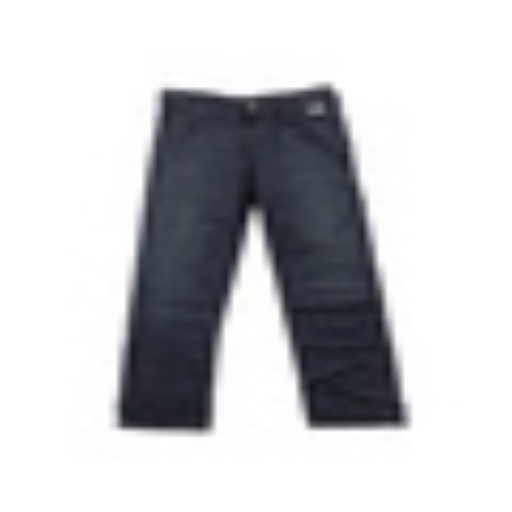

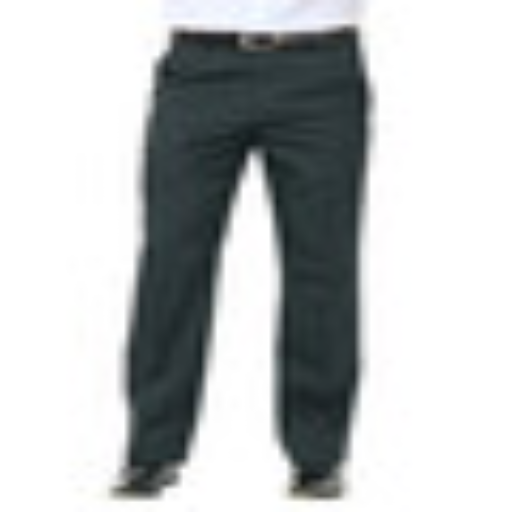

In [38]:
neighbors = NearestNeighbors(n_neighbors=6,algorithm='brute',metric='euclidean')
neighbors.fit(feature_list)

distances,indices = neighbors.kneighbors([normalized_result])

print(indices)

for file in indices[0][1:6]:
    temp_img = cv2.imread(filenames[file])
    cv2_imshow(cv2.resize(temp_img,(512,512)))
    cv2.waitKey(0)